## General information
This is a basic kernel with CNN. In this kernel I train a CNN model on folds and calculate the competition metric (not simple auc).

## Content

* [1 Loading and processing data](#load)
* [2 Validation functions](#valid)
* [3 Model](#model)
* [4 Training function](#train)
* [5 Train and predict](#run)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from nltk.tokenize import TweetTokenizer
import datetime
import lightgbm as lgb
from scipy import stats
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
pd.set_option('max_colwidth',400)
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Conv1D, GRU, CuDNNGRU, CuDNNLSTM, BatchNormalization
from keras.layers import Bidirectional, GlobalMaxPool1D, MaxPooling1D, Add, Flatten
from keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate, SpatialDropout1D
from keras.models import Model, load_model
from keras import initializers, regularizers, constraints, optimizers, layers, callbacks
from keras import backend as K
from keras.engine import InputSpec, Layer
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, TensorBoard, Callback, EarlyStopping

import time
import os
print(os.listdir("../input"))


Using TensorFlow backend.


['jigsaw-public-files', 'glove840b300dtxt', 'fasttext-crawl-300d-2m', 'jigsaw-unintended-bias-in-toxicity-classification']


<a id="load"></a>
## Loading data

I'll load preprocessed data from my dataset

In [2]:
train = pd.read_csv('../input/jigsaw-public-files/train.csv')
test = pd.read_csv('../input/jigsaw-public-files/test.csv')
# after processing some of the texts are emply
train['comment_text'] = train['comment_text'].fillna('')
test['comment_text'] = test['comment_text'].fillna('')
sub = pd.read_csv('../input/jigsaw-unintended-bias-in-toxicity-classification/sample_submission.csv')

In [3]:
full_text = list(train['comment_text'].values) + list(test['comment_text'].values)
max_features = 300000
tk = Tokenizer(lower = True, filters='', num_words=max_features)
tk.fit_on_texts(full_text)

In [4]:
embedding_path1 = "../input/fasttext-crawl-300d-2m/crawl-300d-2M.vec"
embedding_path2 = "../input/glove840b300dtxt/glove.840B.300d.txt"
embed_size = 300

In [5]:
def get_coefs(word,*arr):
    return word, np.asarray(arr, dtype='float32')

def build_matrix(embedding_path, tokenizer):
    embedding_index = dict(get_coefs(*o.strip().split(" ")) for o in open(embedding_path))

    word_index = tk.word_index
    nb_words = min(max_features, len(word_index))
    embedding_matrix = np.zeros((nb_words + 1, embed_size))
    for word, i in word_index.items():
        if i >= max_features:
            continue
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

# combining embeddings from this kernel: https://www.kaggle.com/tanreinama/simple-lstm-using-identity-parameters-solution
embedding_matrix = np.concatenate([build_matrix(embedding_path1, tk), build_matrix(embedding_path2, tk)], axis=-1)

In [6]:
y = np.where(train['target'] >= 0.5, True, False) * 1

In [7]:
identity_columns = ['male', 'female', 'homosexual_gay_or_lesbian', 'christian', 'jewish', 'muslim', 'black', 'white', 'psychiatric_or_mental_illness']
for col in identity_columns + ['target']:
    train[col] = np.where(train[col] >= 0.5, True, False)

n_fold = 5
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=11)

<a id="valid"></a>
## Validation functions

In [8]:
SUBGROUP_AUC = 'subgroup_auc'
BPSN_AUC = 'bpsn_auc'  # stands for background positive, subgroup negative
BNSP_AUC = 'bnsp_auc'  # stands for background negative, subgroup positive

def compute_auc(y_true, y_pred):
    try:
        return metrics.roc_auc_score(y_true, y_pred)
    except ValueError:
        return np.nan

def compute_subgroup_auc(df, subgroup, label, oof_name):
    subgroup_examples = df[df[subgroup]]
    return compute_auc(subgroup_examples[label], subgroup_examples[oof_name])

def compute_bpsn_auc(df, subgroup, label, oof_name):
    """Computes the AUC of the within-subgroup negative examples and the background positive examples."""
    subgroup_negative_examples = df[df[subgroup] & ~df[label]]
    non_subgroup_positive_examples = df[~df[subgroup] & df[label]]
    examples = subgroup_negative_examples.append(non_subgroup_positive_examples)
    return compute_auc(examples[label], examples[oof_name])

def compute_bnsp_auc(df, subgroup, label, oof_name):
    """Computes the AUC of the within-subgroup positive examples and the background negative examples."""
    subgroup_positive_examples = df[df[subgroup] & df[label]]
    non_subgroup_negative_examples = df[~df[subgroup] & ~df[label]]
    examples = subgroup_positive_examples.append(non_subgroup_negative_examples)
    return compute_auc(examples[label], examples[oof_name])

def compute_bias_metrics_for_model(dataset,
                                   subgroups,
                                   model,
                                   label_col,
                                   include_asegs=False):
    """Computes per-subgroup metrics for all subgroups and one model."""
    records = []
    for subgroup in subgroups:
        record = {
            'subgroup': subgroup,
            'subgroup_size': len(dataset[dataset[subgroup]])
        }
        record[SUBGROUP_AUC] = compute_subgroup_auc(dataset, subgroup, label_col, model)
        record[BPSN_AUC] = compute_bpsn_auc(dataset, subgroup, label_col, model)
        record[BNSP_AUC] = compute_bnsp_auc(dataset, subgroup, label_col, model)
        records.append(record)
    return pd.DataFrame(records).sort_values('subgroup_auc', ascending=True)

def calculate_overall_auc(df, oof_name):
    true_labels = df['target']
    predicted_labels = df[oof_name]
    return metrics.roc_auc_score(true_labels, predicted_labels)

def power_mean(series, p):
    total = sum(np.power(series, p))
    return np.power(total / len(series), 1 / p)

def get_final_metric(bias_df, overall_auc, POWER=-5, OVERALL_MODEL_WEIGHT=0.25):
    bias_score = np.average([
        power_mean(bias_df[SUBGROUP_AUC], POWER),
        power_mean(bias_df[BPSN_AUC], POWER),
        power_mean(bias_df[BNSP_AUC], POWER)
    ])
    return (OVERALL_MODEL_WEIGHT * overall_auc) + ((1 - OVERALL_MODEL_WEIGHT) * bias_score)
    

<a id="model"></a>
## Model

In [9]:
# adding attention from this kernel: https://www.kaggle.com/christofhenkel/keras-baseline-lstm-attention-5-fold
class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim
    

def build_model(X_train, y_train, X_valid, y_valid, max_len, max_features, embed_size, embedding_matrix, lr=0.0, lr_d=0.0, spatial_dr=0.0,
                dense_units=128, conv_size=128, dr=0.2, patience=3, fold_id=1):
    file_path = f"best_model_fold_{fold_id}.hdf5"
    check_point = ModelCheckpoint(file_path, monitor="val_loss", verbose=1,save_best_only=True, mode="min")
    early_stop = EarlyStopping(monitor="val_loss", mode="min", patience=patience)
    
    inp = Input(shape = (max_len,))
    x = Embedding(max_features + 1, embed_size * 2, weights=[embedding_matrix], trainable=False)(inp)
    x1 = SpatialDropout1D(spatial_dr)(x)
    att = Attention(max_len)(x1)
    # from benchmark kernel
    x = Conv1D(conv_size, 2, activation='relu', padding='same')(x1)
    x = MaxPooling1D(5, padding='same')(x)
    x = Conv1D(conv_size, 3, activation='relu', padding='same')(x)
    x = MaxPooling1D(5, padding='same')(x)
    x = Flatten()(x)
    x = concatenate([x, att])
    
    x = Dropout(dr)(Dense(dense_units, activation='relu') (x))
    x = Dense(1, activation="sigmoid")(x)
    
    model = Model(inputs=inp, outputs=x)
    model.compile(loss="binary_crossentropy", optimizer=Adam(lr=lr, decay=lr_d), metrics=["accuracy"])
    model.fit(X_train, y_train, batch_size=128, epochs=3, validation_data=(X_valid, y_valid), 
                        verbose=2, callbacks=[early_stop, check_point])
    return model

<a id="train"></a>
## Training fuction

In [10]:
def train_model(X, X_test, y, tokenizer, max_len):
    
    oof = np.zeros((len(X), 1))
    prediction = np.zeros((len(X_test), 1))
    scores = []
    test_tokenized = tokenizer.texts_to_sequences(test['comment_text'])
    X_test = pad_sequences(test_tokenized, maxlen = max_len)
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y)):
        print('Fold', fold_n, 'started at', time.ctime())
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        valid_df = X_valid.copy()    

        train_tokenized = tokenizer.texts_to_sequences(X_train['comment_text'])
        valid_tokenized = tokenizer.texts_to_sequences(X_valid['comment_text'])

        X_train = pad_sequences(train_tokenized, maxlen = max_len)
        X_valid = pad_sequences(valid_tokenized, maxlen = max_len)
        
        model = build_model(X_train, y_train, X_valid, y_valid, max_len, max_features, embed_size, embedding_matrix,
                            lr = 1e-3, lr_d = 0, spatial_dr = 0.1, dense_units=128, conv_size=128, dr=0.1, patience=3, fold_id=fold_n)
        
        pred_valid = model.predict(X_valid)
        oof[valid_index] = pred_valid
        valid_df[oof_name] = pred_valid
        
        bias_metrics_df = compute_bias_metrics_for_model(valid_df, identity_columns, oof_name, 'target')
        scores.append(get_final_metric(bias_metrics_df, calculate_overall_auc(valid_df, oof_name)))
        
        prediction += model.predict(X_test, batch_size = 1024, verbose = 1)
    
    prediction /= n_fold
    
    # print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    return oof, prediction, scores

<a id="run"></a>
## Train and predict

In [11]:
oof_name = 'predicted_target'
max_len = 250
oof, prediction, scores = train_model(X=train, X_test=test, y=train['target'], tokenizer=tk, max_len=max_len)
print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))

Fold 0 started at Sun May 12 17:03:22 2019
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 1443899 samples, validate on 360975 samples
Epoch 1/3
 - 167s - loss: 0.1348 - acc: 0.9477 - val_loss: 0.1245 - val_acc: 0.9506

Epoch 00001: val_loss improved from inf to 0.12447, saving model to best_model_fold_0.hdf5
Epoch 2/3
 - 165s - loss: 0.1233 - acc: 0.9511 - val_loss: 0.1201 - val_acc: 0.9519

Epoch 00002: val_loss improved from 0.12447 to 0.12005, saving model to best_model_fold_0.hdf5
Epoch 3/3
 - 165s - loss: 0.1192 - acc: 0.9523 - val_loss: 0.1196 - val_acc: 0.9522

Epoch 00003: val_loss improved from 0.12005 to 0.11957, saving model to best_model_fold_0.hdf5
97320/97320 [==============================] - 3s 33us/step
Fold 1 started at Sun May 12 17:13:53 2019
Train on 1443899 samples, vali

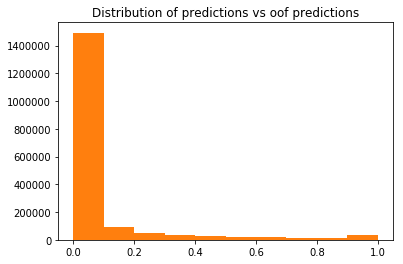

In [12]:
plt.hist(prediction);
plt.hist(oof);
plt.title('Distribution of predictions vs oof predictions');

In [13]:
sub['prediction'] = prediction
sub.to_csv('submission.csv', index=False)